Celem tego krótkiego badania jest sprawdzenie jakiej wielkości sieć neuronowa jest potrzebna do otrzymania zadowalającej estymacji kształtu sinusoidy

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchsummary import summary
from torchviz import make_dot
from IPython.display import Image, display
import os
from sklearn.metrics import mean_squared_error, r2_score

os.environ["PATH"] += (
    os.pathsep
    + "D:/windows_10_cmake_Release_Graphviz-12.2.1-win64/Graphviz-12.2.1-win64/bin"
)

In [2]:
# Ustawiamy seed dla powtarzalności wyników
SEED = 44
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# seed dla pytorch
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
# Funkcja generująca sinusoidę
def sinusoida(n_samples=1000):
    x = np.linspace(0, 2 * np.pi, n_samples)
    y = np.sin(x)
    return x, y


n_samples = 1000
x, y = sinusoida(n_samples=n_samples)

# Zamiana na tym danych pytorch
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Stworzenie zbioru testowego i treningowego
x_train, x_test, y_train, y_test = train_test_split(
    x_tensor, y_tensor, test_size=0.2, random_state=42
)

# Ustalenie podzespołu wykonującego obliczenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

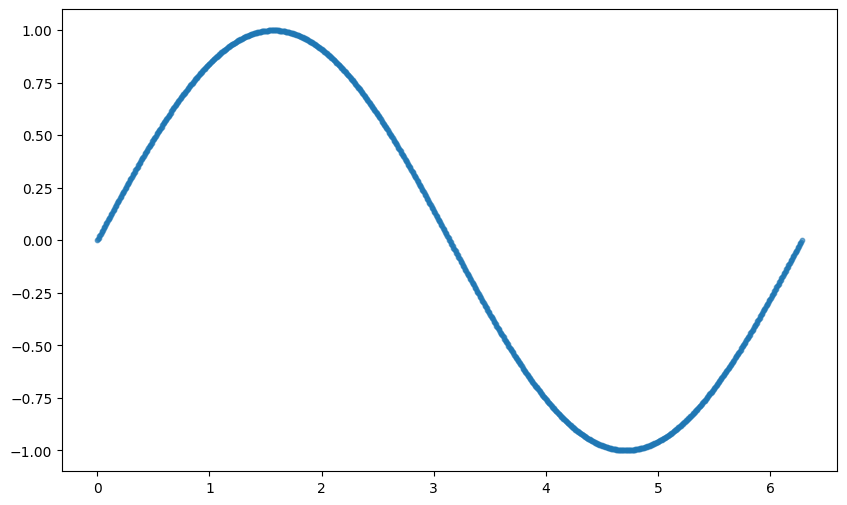

In [4]:
# Wziualizacja sinusoidy
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)

In [5]:
# Definijuem model sieci neuronowej
class SinusoidNN(nn.Module):
    def __init__(self):
        super(SinusoidNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(
                1, 2
            ),  # Pierwsza warstwa zawiera jeden neuron wejściowy, i dwie wagi wychodzące
            nn.Tanh(),  # Następnie wchodzimy do warstwy ukrytej która składa się z 2 neuronów
            nn.Linear(2, 1),  # Ostatni neuron generujący wynik
        )

    def forward(self, x):
        return self.network(x)


model = SinusoidNN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Podsumowanie modelu
summary(model, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 2]               4
              Tanh-2                    [-1, 2]               0
            Linear-3                    [-1, 1]               3
Total params: 7
Trainable params: 7
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


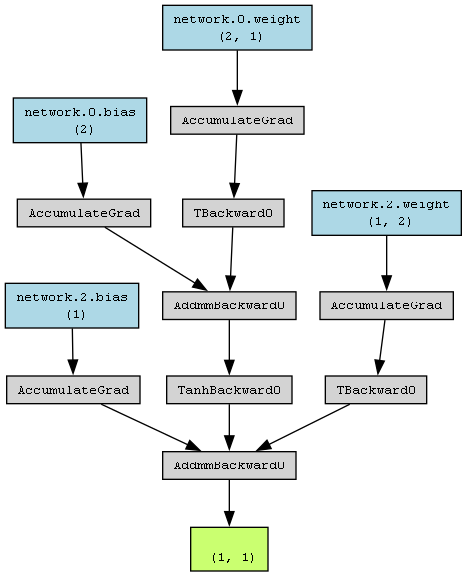

In [6]:
def visualize_model_graph(model, device):
    sample_input = torch.randn(1, 1).to(device)  # Move input to the correct device
    output = model(sample_input)  # Forward pass
    graph = make_dot(output, params=dict(model.named_parameters()))
    # Render and display the graph in the notebook
    graph.render("sinusoid_nn", format="png", cleanup=True)
    display(Image("sinusoid_nn.png"))


visualize_model_graph(model, device)

In [7]:
# Ustalamy liczbę epok ze względu na prostotę modelu można ustwaić tu dosyć wysoką wartość bez obaw o zbyt długie trenowanie
n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.2426
Epoch [200/1000], Loss: 0.1528
Epoch [300/1000], Loss: 0.0953
Epoch [400/1000], Loss: 0.0370
Epoch [500/1000], Loss: 0.0361
Epoch [600/1000], Loss: 0.0357
Epoch [700/1000], Loss: 0.0353
Epoch [800/1000], Loss: 0.0349
Epoch [900/1000], Loss: 0.0346
Epoch [1000/1000], Loss: 0.0339


In [8]:
# Obliczamy predykjce dla zbioru testowego
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

In [9]:
def statystyki(real_values, test_predictions):
    rmse = np.sqrt(mean_squared_error(real_values, test_predictions))
    r2 = r2_score(real_values, test_predictions)
    return r2, rmse


r2, rmse = statystyki(y_test.cpu().numpy(), y_test_pred.cpu().numpy())

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.1920
R² Score: 0.9285


 Średnio przewidywane wartości różnią się od rzeczywistych o około 0.192.
 <br>
 Wartość 0.9285 oznacza, że 92.85% zmienności w danych jest wyjaśnione przez model, co wskazuje na bardzo dobre dopasowanie.

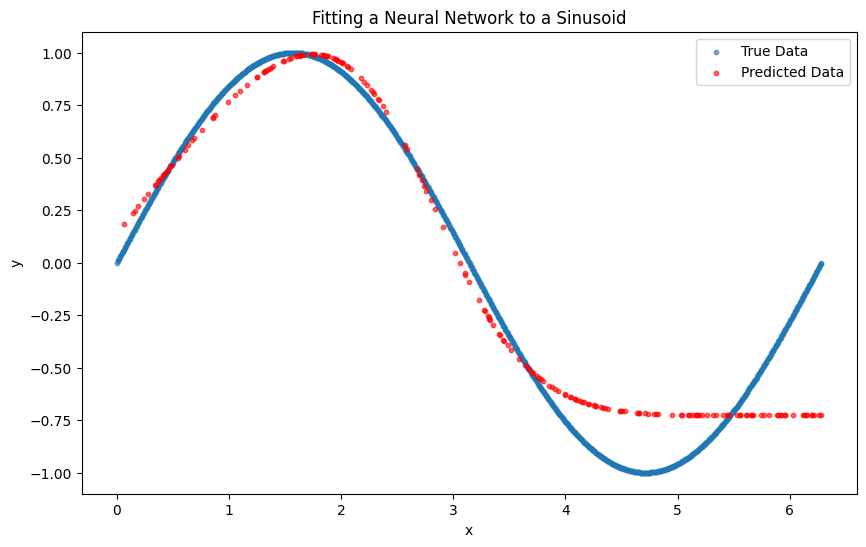

In [10]:
# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)
plt.scatter(
    x_test.cpu().numpy(),
    y_test_pred.cpu().numpy(),
    label="Predicted Data",
    s=10,
    color="red",
    alpha=0.6,
)
plt.title("Fitting a Neural Network to a Sinusoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Jak widać wyniki uzyskane przez sieć neuronową składającą się z 2 neuronów są całkiem niezłe
<br>
Sprawdźmy czy model jest w stanie nauczyć się czegoś więcej po zwiększeniu ilości epok

In [11]:
model = SinusoidNN()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 10000
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [1000/10000], Loss: 0.0264
Epoch [2000/10000], Loss: 0.0071
Epoch [3000/10000], Loss: 0.0037
Epoch [4000/10000], Loss: 0.0023
Epoch [5000/10000], Loss: 0.0015
Epoch [6000/10000], Loss: 0.0011
Epoch [7000/10000], Loss: 0.0009
Epoch [8000/10000], Loss: 0.0007
Epoch [9000/10000], Loss: 0.0006
Epoch [10000/10000], Loss: 0.0005


In [12]:
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

r2, rmse = statystyki(y_test.cpu().numpy(), y_test_pred.cpu().numpy())

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.0218
R² Score: 0.9991


 Średnio przewidywane wartości różnią się od rzeczywistych o około 0.021 (Wcześniej 0.192).
 <br>
 Wartość 0.9991 (Wcześniej 0.9285) oznacza, że 99.91% zmienności w danych jest wyjaśnione przez model, co wskazuje na niemal idelane dopasowanie.

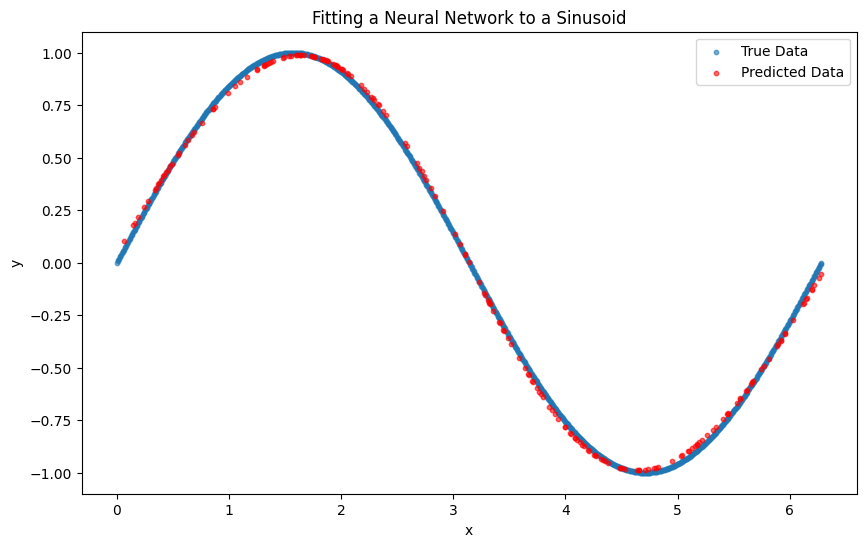

In [13]:
# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)
plt.scatter(
    x_test.cpu().numpy(),
    y_test_pred.cpu().numpy(),
    label="Predicted Data",
    s=10,
    color="red",
    alpha=0.6,
)
plt.title("Fitting a Neural Network to a Sinusoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

No dobrze a co w przypadku dla większej liczby okresów?

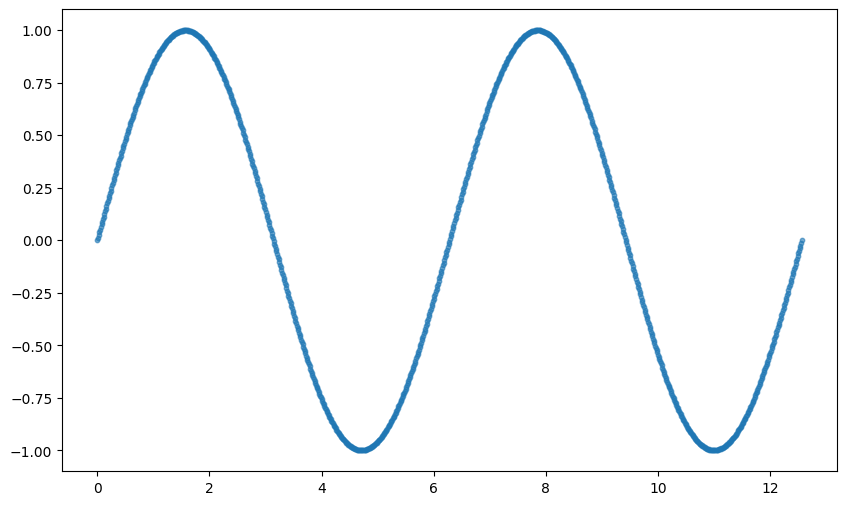

In [14]:
def sinusoida(n_samples=1000):
    x = np.linspace(0, 4 * np.pi, n_samples)
    y = np.sin(x)
    return x, y


n_samples = 1000
x, y = sinusoida(n_samples=n_samples)

# Zamiana na tym danych pytorch
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# Stworzenie zbioru testowego i treningowego
x_train, x_test, y_train, y_test = train_test_split(
    x_tensor, y_tensor, test_size=0.2, random_state=42
)

# Ustalenie podzespołu wykonującego obliczenia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_train = x_train.to(device)
x_test = x_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

# Wziualizacja sinusoidy
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)

In [15]:
model = SinusoidNN()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

n_epochs = 1000
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [100/1000], Loss: 0.4636
Epoch [200/1000], Loss: 0.3905
Epoch [300/1000], Loss: 0.3537
Epoch [400/1000], Loss: 0.3406
Epoch [500/1000], Loss: 0.3381
Epoch [600/1000], Loss: 0.3371
Epoch [700/1000], Loss: 0.3365
Epoch [800/1000], Loss: 0.3361
Epoch [900/1000], Loss: 0.3357
Epoch [1000/1000], Loss: 0.3354


In [16]:
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

r2, rmse = statystyki(y_test.cpu().numpy(), y_test_pred.cpu().numpy())

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.6159
R² Score: 0.2380


Statystyki są o wiele gorsze

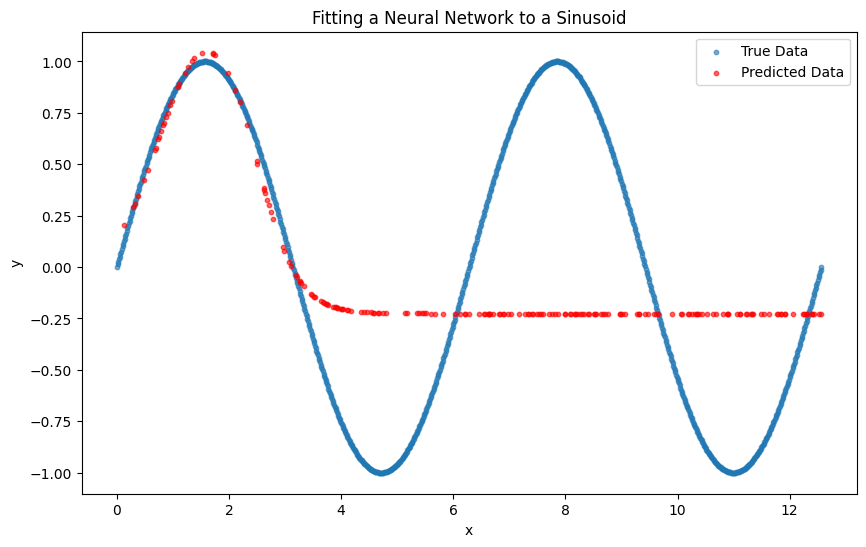

In [17]:
# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)
plt.scatter(
    x_test.cpu().numpy(),
    y_test_pred.cpu().numpy(),
    label="Predicted Data",
    s=10,
    color="red",
    alpha=0.6,
)
plt.title("Fitting a Neural Network to a Sinusoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Jak widać w tym wypadku sieć nie była w stanie dopasować się tak dobrze
<br>
Spróbujmy zatem dodać dodatkowy neuron w warstwie ukrytej zwiększając tym samym liczbę neuronów do 3

In [18]:
# Definijuem model sieci neuronowej
class SinusoidNN(nn.Module):
    def __init__(self):
        super(SinusoidNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(
                1, 3
            ),  # Pierwsza warstwa zawiera jeden neuron wejściowy, i dwie wagi wychodzące
            nn.Tanh(),  # Następnie wchodzimy do warstwy ukrytej która składa się z 2 neuronów
            nn.Linear(3, 1),  # Ostatni neuron generujący wynik
        )

    def forward(self, x):
        return self.network(x)


model = SinusoidNN()
model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Podsumowanie modelu
summary(model, input_size=(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]               6
              Tanh-2                    [-1, 3]               0
            Linear-3                    [-1, 1]               4
Total params: 10
Trainable params: 10
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [19]:
n_epochs = 10000
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [1000/10000], Loss: 0.3346
Epoch [2000/10000], Loss: 0.3334
Epoch [3000/10000], Loss: 0.3332
Epoch [4000/10000], Loss: 0.3332
Epoch [5000/10000], Loss: 0.3332
Epoch [6000/10000], Loss: 0.0458
Epoch [7000/10000], Loss: 0.0420
Epoch [8000/10000], Loss: 0.0408
Epoch [9000/10000], Loss: 0.0402
Epoch [10000/10000], Loss: 0.0398


In [20]:
model.eval()
with torch.no_grad():
    y_test_pred = model(x_test)

r2, rmse = statystyki(y_test.cpu().numpy(), y_test_pred.cpu().numpy())

print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

RMSE: 0.2204
R² Score: 0.9024


Statystyki są bardzo podobne to tych uzsykanych dla pierwszego modelu i krótszej sinusoidy

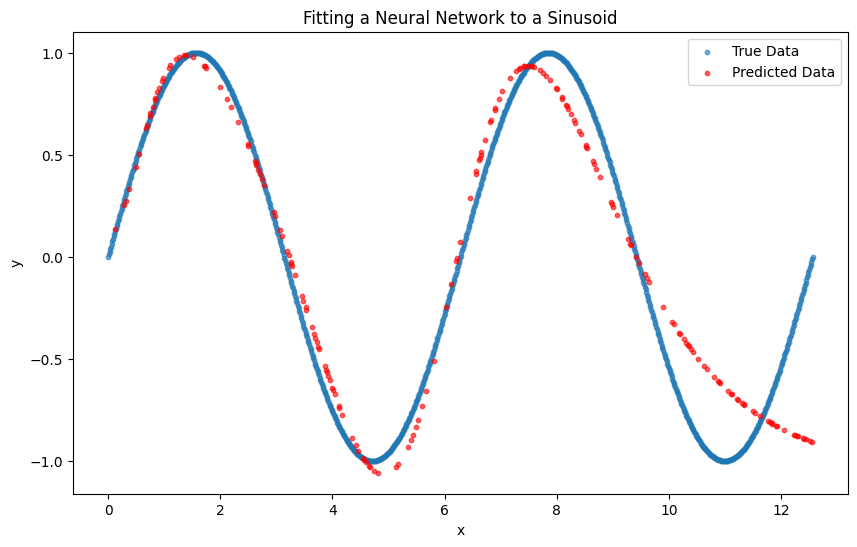

In [21]:
# Wizualizacja wyników
plt.figure(figsize=(10, 6))
plt.scatter(x, y, label="True Data", s=10, alpha=0.6)
plt.scatter(
    x_test.cpu().numpy(),
    y_test_pred.cpu().numpy(),
    label="Predicted Data",
    s=10,
    color="red",
    alpha=0.6,
)
plt.title("Fitting a Neural Network to a Sinusoid")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

Jak widać wyniki poprawiły się 
<br>
Słowem podsumowania widać, że przy budowie modelu wielkość sieci powinna być związana z długością sinusoidy którą chcemy estymować.
<br>
Z pewnością kwestią dyskusyjną jest czy faktycznie do tak prostej estymacji powinna być potrzebna tak duża liczba epok
<br>
Natomiast w naszym przypadku nie robiliśmy testów na innych funkcjach aktywacji i propagacji wstecznej być może to poprawiłoby rezultaty